In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')

In [3]:
del df['id']

In [4]:
assert df.isnull().sum().sum() == 0

In [5]:
dummy_df = pd.get_dummies(df)

In [6]:
cont_vars = [c for c in dummy_df.columns if c.startswith('con')]
cat_vars = [c for c in dummy_df.columns if c.startswith('cat')]
features = cont_vars + cat_vars

## Continuous Variables Correlation

In [7]:
corr = df[cont_vars].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

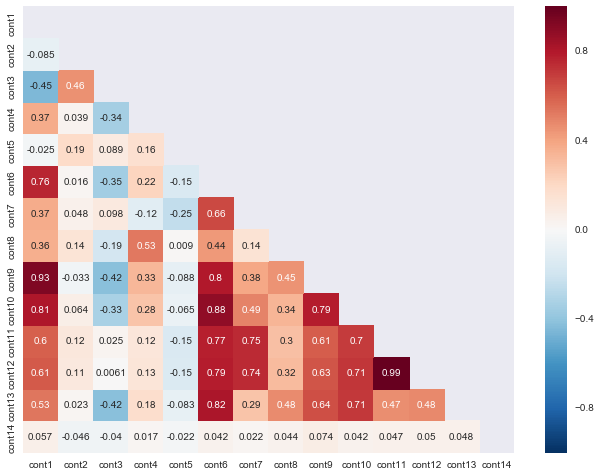

In [8]:
plt.figure(figsize=(11, 8))
sns.heatmap(corr, mask=mask, annot=True)

## Lasso Model

In [8]:
from sklearn.linear_model import LassoCV, Lasso
from scipy.stats import skew

Model without any feature engineering

In [9]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [24]:
lasso_model_1 = LassoCV(alphas=alphas, n_jobs=-1, max_iter=10000, tol=0.01).fit(
    dummy_df[features], dummy_df['loss']
)

D:\Users\zeyang\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [25]:
lasso_model_1.alpha_

0.10000000000000001

In [26]:
np.sqrt(np.sum(np.square(dummy_df['loss'] - lasso_model_1.predict(dummy_df[features])) / len(dummy_df)))

2001.1014200223017

Model with normalized continuous variables

In [38]:
lasso_model_2 = LassoCV(alphas=alphas, n_jobs=-1, max_iter=100000, tol=0.0001, normalize=True).fit(
    dummy_df[features], dummy_df['loss']
)

In [39]:
lasso_model_2.alpha_

0.01

In [40]:
np.sqrt(np.sum(np.square(dummy_df['loss'] - lasso_model_2.predict(dummy_df[features])) / len(dummy_df)))

1997.1723930184039

Model with log(Y)<br>
Because Y has skewness problem, it breaks linear model's assumption about target value distribution, let's correct this.

In [41]:
lasso_model_3 = LassoCV(alphas=alphas, n_jobs=-1, max_iter=10000, tol=0.0001).fit(
    dummy_df[features], np.log(dummy_df['loss'])
)

In [42]:
lasso_model_3.alpha_

0.001

In [43]:
np.sqrt(np.sum(np.square(dummy_df['loss'] - np.exp(lasso_model_3.predict(dummy_df[features]))) / len(dummy_df)))

2210.370465969716

Model with normalized features and log(Y)

In [44]:
lasso_model_4 = LassoCV(alphas=alphas, n_jobs=-1, max_iter=10000, tol=0.0001, normalize=True).fit(
    dummy_df[features], np.log(dummy_df['loss'])
)

In [46]:
lasso_model_4.alpha_

0.001

In [45]:
np.sqrt(np.sum(np.square(dummy_df['loss'] - np.exp(lasso_model_4.predict(dummy_df[features]))) / len(dummy_df)))

3029.1060659120808

Best model is Lasso with alpha 0.01, normalized X

In [30]:
coef = pd.Series(lasso_model_2.coef_, index=features)

In [31]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 573 variables and eliminated the other 580 variables


In [32]:
imp_coef = pd.concat([coef.sort_values().head(15),
                      coef.sort_values().tail(15)])

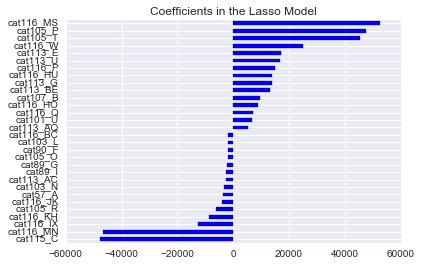

In [33]:
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

## Ridge Model

In [34]:
from sklearn.linear_model import RidgeCV

In [11]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

Regular ridge model

In [66]:
ridge_model_1 = RidgeCV(alphas, ).fit(dummy_df[features], dummy_df['loss'])

In [67]:
ridge_model_1.alpha_

1.0

In [68]:
np.sqrt(np.sum(np.square(dummy_df['loss'] - ridge_model_1.predict(dummy_df[features])) / len(dummy_df)))

1996.8266397436792

Ridge model with normalized X regressor

In [51]:
ridge_model_2 = RidgeCV(alphas, normalize=True).fit(dummy_df[features], dummy_df['loss'])

In [53]:
ridge_model_2.alpha_

0.10000000000000001

In [54]:
np.sqrt(np.sum(np.square(dummy_df['loss'] - ridge_model_2.predict(dummy_df[features])) / len(dummy_df)))

1997.220603978091

Ridge model with log(Y)

In [58]:
ridge_model_3 = RidgeCV(alphas).fit(dummy_df[features], np.log(dummy_df['loss']))

In [59]:
ridge_model_3.alpha_

10.0

In [61]:
np.sqrt(np.sum(np.square(dummy_df['loss'] - np.exp(ridge_model_3.predict(dummy_df[features]))) / len(dummy_df)))

2169.6402548031833

Ridge model with normalized regressor and log(Y)

In [63]:
ridge_model_4 = RidgeCV(alphas, normalize=True).fit(dummy_df[features], np.log(dummy_df['loss']))

In [64]:
ridge_model_4.alpha_

0.01

In [65]:
np.sqrt(np.sum(np.square(dummy_df['loss'] - np.exp(ridge_model_4.predict(dummy_df[features]))) / len(dummy_df)))

2138.8223884101831

The regular one performs best in the training dataset

In [70]:
coef = pd.Series(ridge_model_1.coef_, index=features)

In [71]:
imp_coef = pd.concat([coef.sort_values().head(15),
                      coef.sort_values().tail(15)])

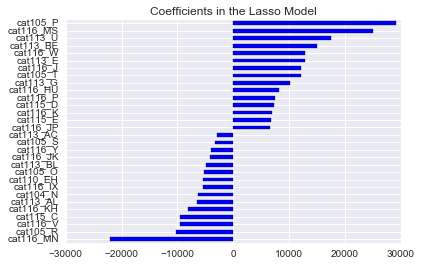

In [72]:
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

## ElasticNet

Regular model

In [7]:
from sklearn.linear_model import ElasticNetCV

In [8]:
l1_ratio = [.1, .5, .7, .9, .95, .99, 1]
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [11]:
# Too expensive

In [12]:
#elastic_model_1 = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, tol=0.001, max_iter=10000, n_jobs=6).fit(dummy_df[features], dummy_df['loss'])